In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import multivae
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-package

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [7]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/'

## scRNA

In [8]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna = scrna[scrna.obs['condition'] == 'control']
scrna

CPU times: user 452 ms, sys: 160 ms, total: 612 ms
Wall time: 612 ms


View of AnnData object with n_obs × n_vars = 35582 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [9]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')
scatac = scatac[scatac.obs['condition'] == 'control']
scatac

CPU times: user 1.32 s, sys: 1.84 s, total: 3.15 s
Wall time: 3.14 s


View of AnnData object with n_obs × n_vars = 35038 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

In [10]:
n_samples = min(scrna.shape[0], scatac.shape[0])
sample_indices = np.random.choice(range(n_samples), size=n_samples, replace=False)
scrna = scrna[sample_indices]
scatac = scatac[sample_indices]
print(scrna.shape, scatac.shape)

(35038, 3000) (35038, 20002)


# Train the model

In [11]:
network = multivae.archs.MultiTrVAE([scrna.shape[1], scatac.shape[1]],
                                    n_conditions=2,
                                    eta=1,
                                    alpha=0.0001,
                                    beta=500)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "multi_trvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_0 (InputLayer)             (None, 3000)         0                                            
__________________________________________________________________________________________________
encoder_labels_0 (InputLayer)   (None, 2)            0                                            
__________________________________________________________________________________________________
data_1 (InputLayer)             (None, 20002)        0                                            
__________________________________________________________________________________________________
encoder_labels_1 (InputLayer)   (None, 2)            0                                     

In [12]:
history = network.train([scrna, scatac], n_epochs=1000, batch_size=256, verbose=2, lr_reducer=80, early_stop_limit=100)


Train on 28030 samples, validate on 7008 samples
Epoch 1/1000
 - 31s - loss: 967.4374 - decoder_0_loss: 220.5181 - decoder_1_loss: 740.8785 - decoder_0_kl_loss: 0.0104 - decoder_0_mmd_loss: 5.9555 - decoder_1_kl_loss: 0.0104 - decoder_1_mmd_loss: 5.9555 - val_loss: 1586761.3438 - val_decoder_0_loss: 186.4982 - val_decoder_1_loss: 1504166.0000 - val_decoder_0_kl_loss: 48430.0273 - val_decoder_0_mmd_loss: 26.5435 - val_decoder_1_kl_loss: 48430.0273 - val_decoder_1_mmd_loss: 26.5435
Epoch 2/1000
 - 20s - loss: 898.6692 - decoder_0_loss: 171.3485 - decoder_1_loss: 720.8666 - decoder_0_kl_loss: 1.2863 - decoder_0_mmd_loss: 5.1609 - decoder_1_kl_loss: 1.2863 - decoder_1_mmd_loss: 5.1609 - val_loss: 891.8136 - val_decoder_0_loss: 160.4420 - val_decoder_1_loss: 713.8666 - val_decoder_0_kl_loss: 0.0147 - val_decoder_0_mmd_loss: 17.3142 - val_decoder_1_kl_loss: 0.0147 - val_decoder_1_mmd_loss: 17.3142
Epoch 3/1000
 - 20s - loss: 882.1807 - decoder_0_loss: 165.2848 - decoder_1_loss: 712.3024 - d

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


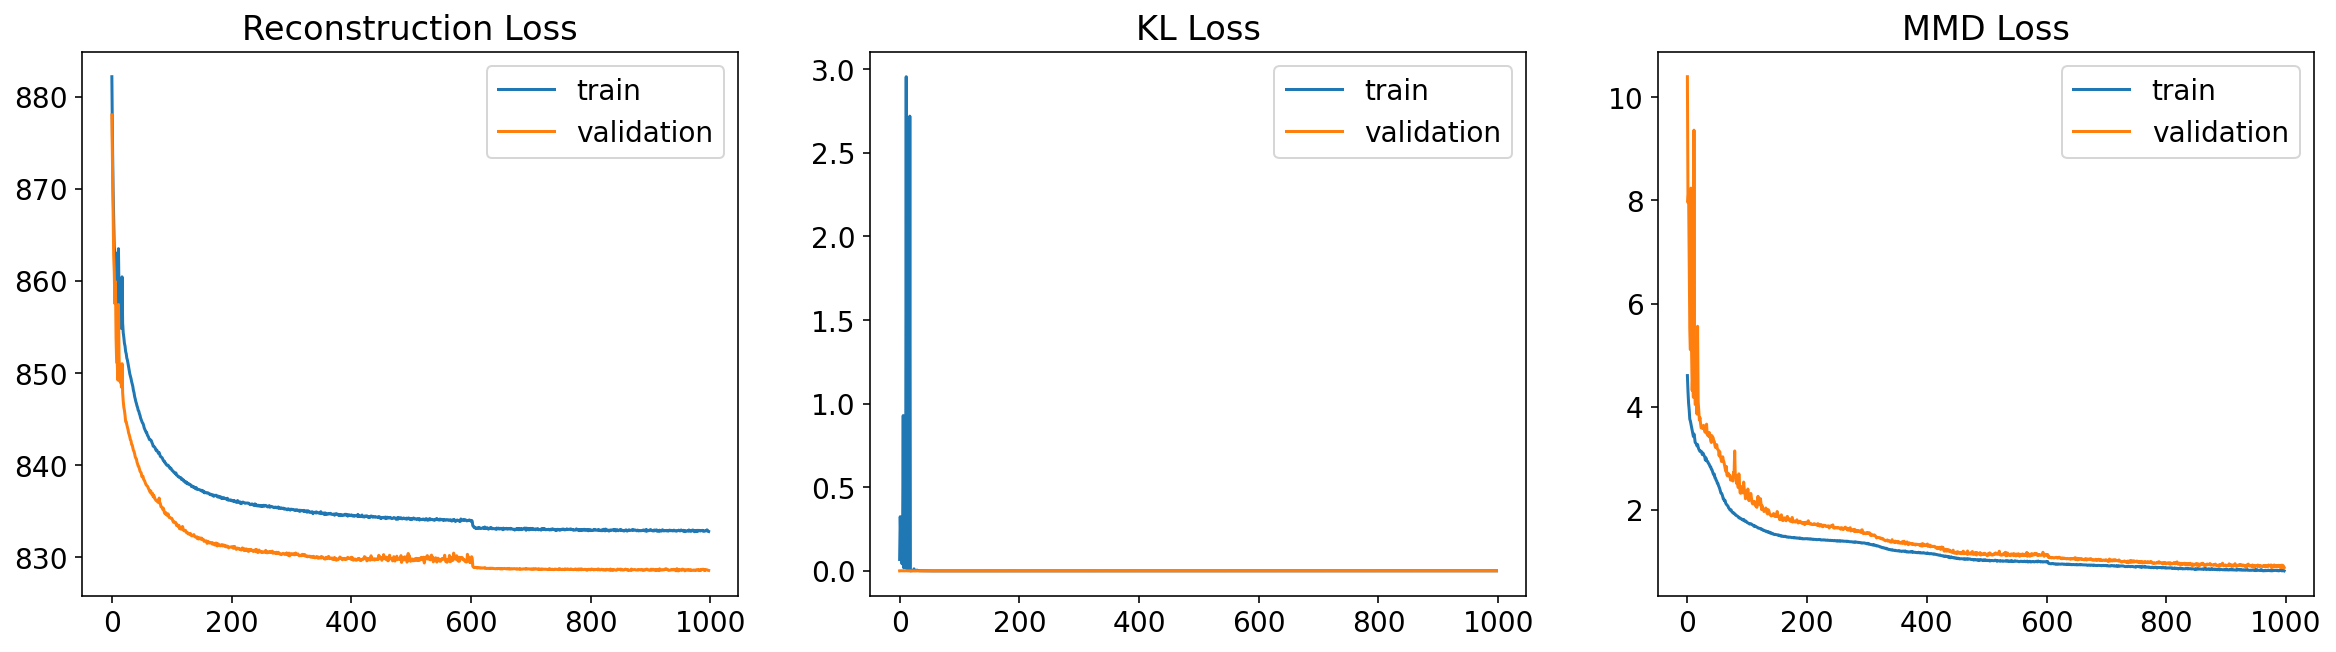

In [13]:
plt.figure(figsize=(20, 5));

plt.subplot(1, 3, 1);
plt.plot(history.history['loss'][2:], label='train');
plt.plot(history.history['val_loss'][2:], label='validation')
plt.title('Reconstruction Loss')
plt.legend();

plt.subplot(1, 3, 2);
plt.plot(history.history['decoder_0_kl_loss'][2:], label='train');
plt.plot(history.history['val_decoder_0_kl_loss'][2:], label='validation');
plt.title('KL Loss')
plt.legend();

plt.subplot(1, 3, 3);
plt.plot(history.history['decoder_0_mmd_loss'][2:], label='train');
plt.plot(history.history['val_decoder_0_mmd_loss'][2:], label='validation')
plt.title('MMD Loss')
plt.legend();

# Visualization

## Latent space of scRNA-seq

In [14]:
scrna_encoder_labels, _ = multivae.utils.label_encoder(scrna, condition_key="condition")
scrna_latent = network.to_latent(scrna, scrna_encoder_labels, modal=0)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

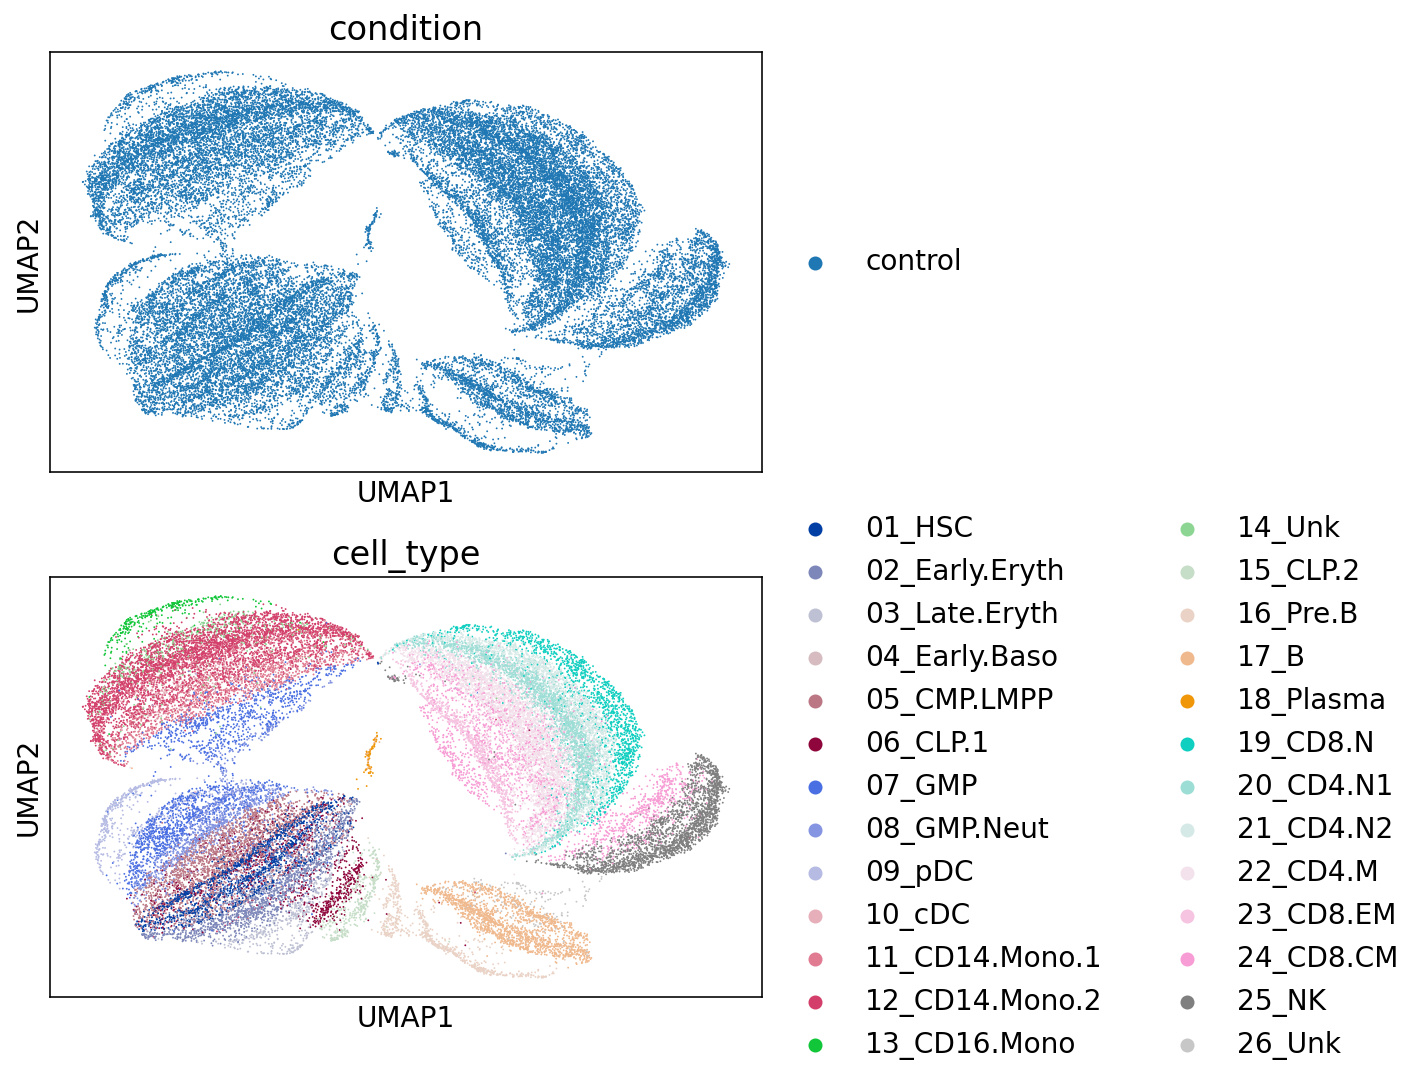

In [15]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of scATAC-seq

In [16]:
scatac_encoder_labels, _ = multivae.utils.label_encoder(scatac, condition_key="condition")
scatac_latent = network.to_latent(scatac, scatac_encoder_labels, modal=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


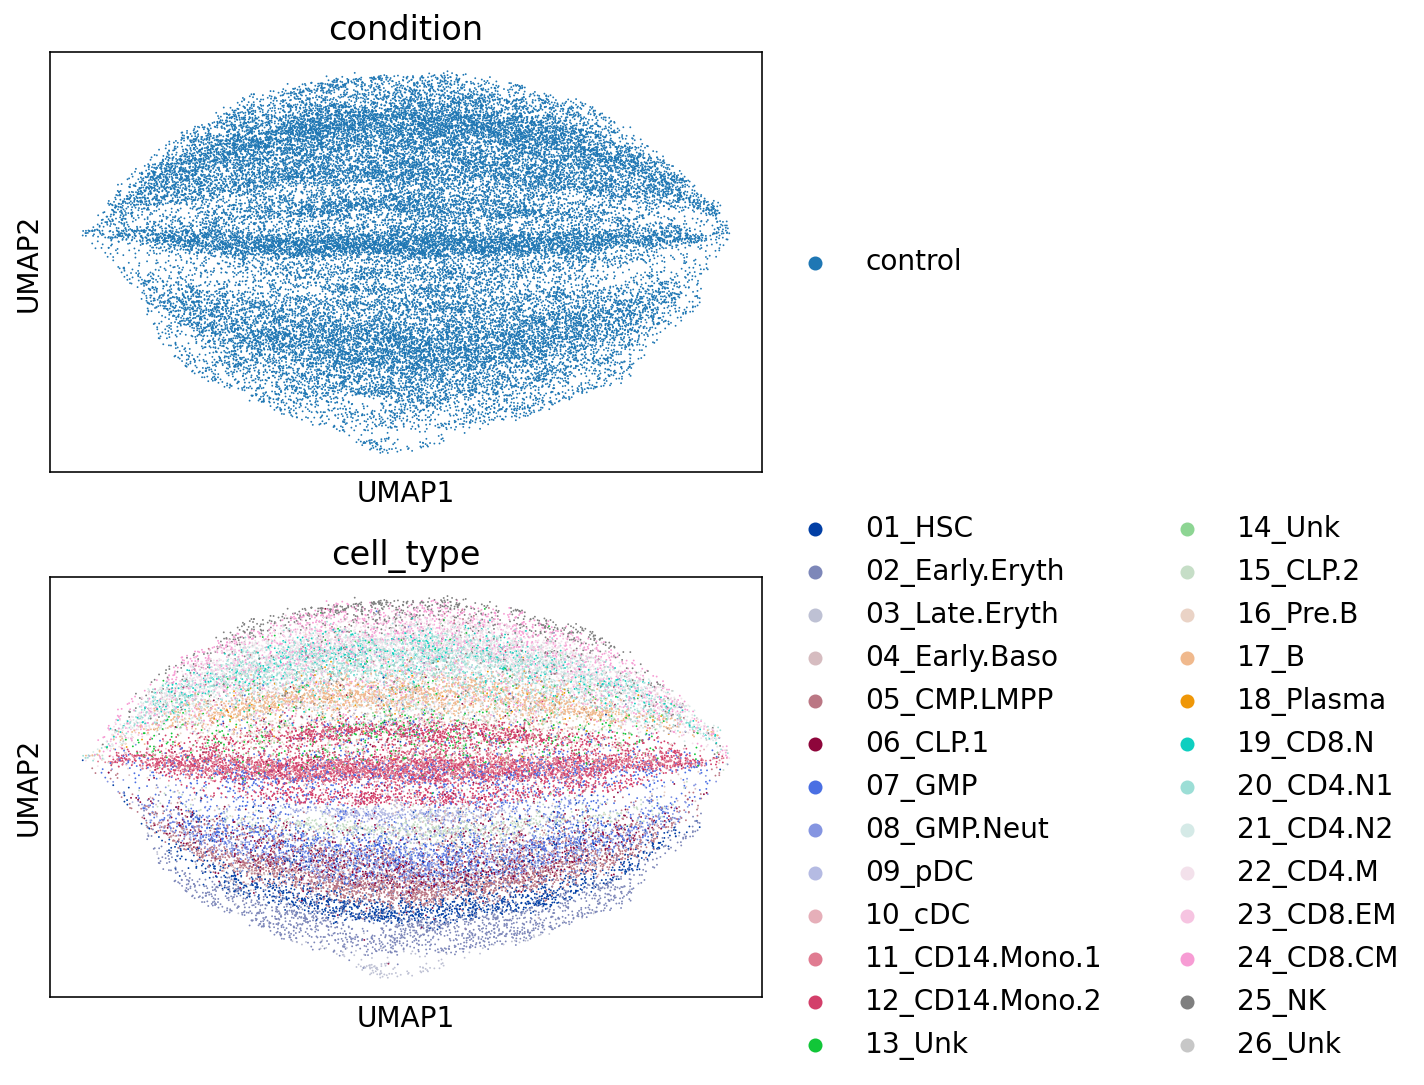

CPU times: user 1min 16s, sys: 1.05 s, total: 1min 17s
Wall time: 52.2 s


In [17]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of both modalities

In [18]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs.copy(deep=True)
scatacobs = scatac.obs.copy(deep=True)
scrnaobs['modality'] = 'scRNA-seq'
scatacobs['modality'] = 'scATAC-seq'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modality' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


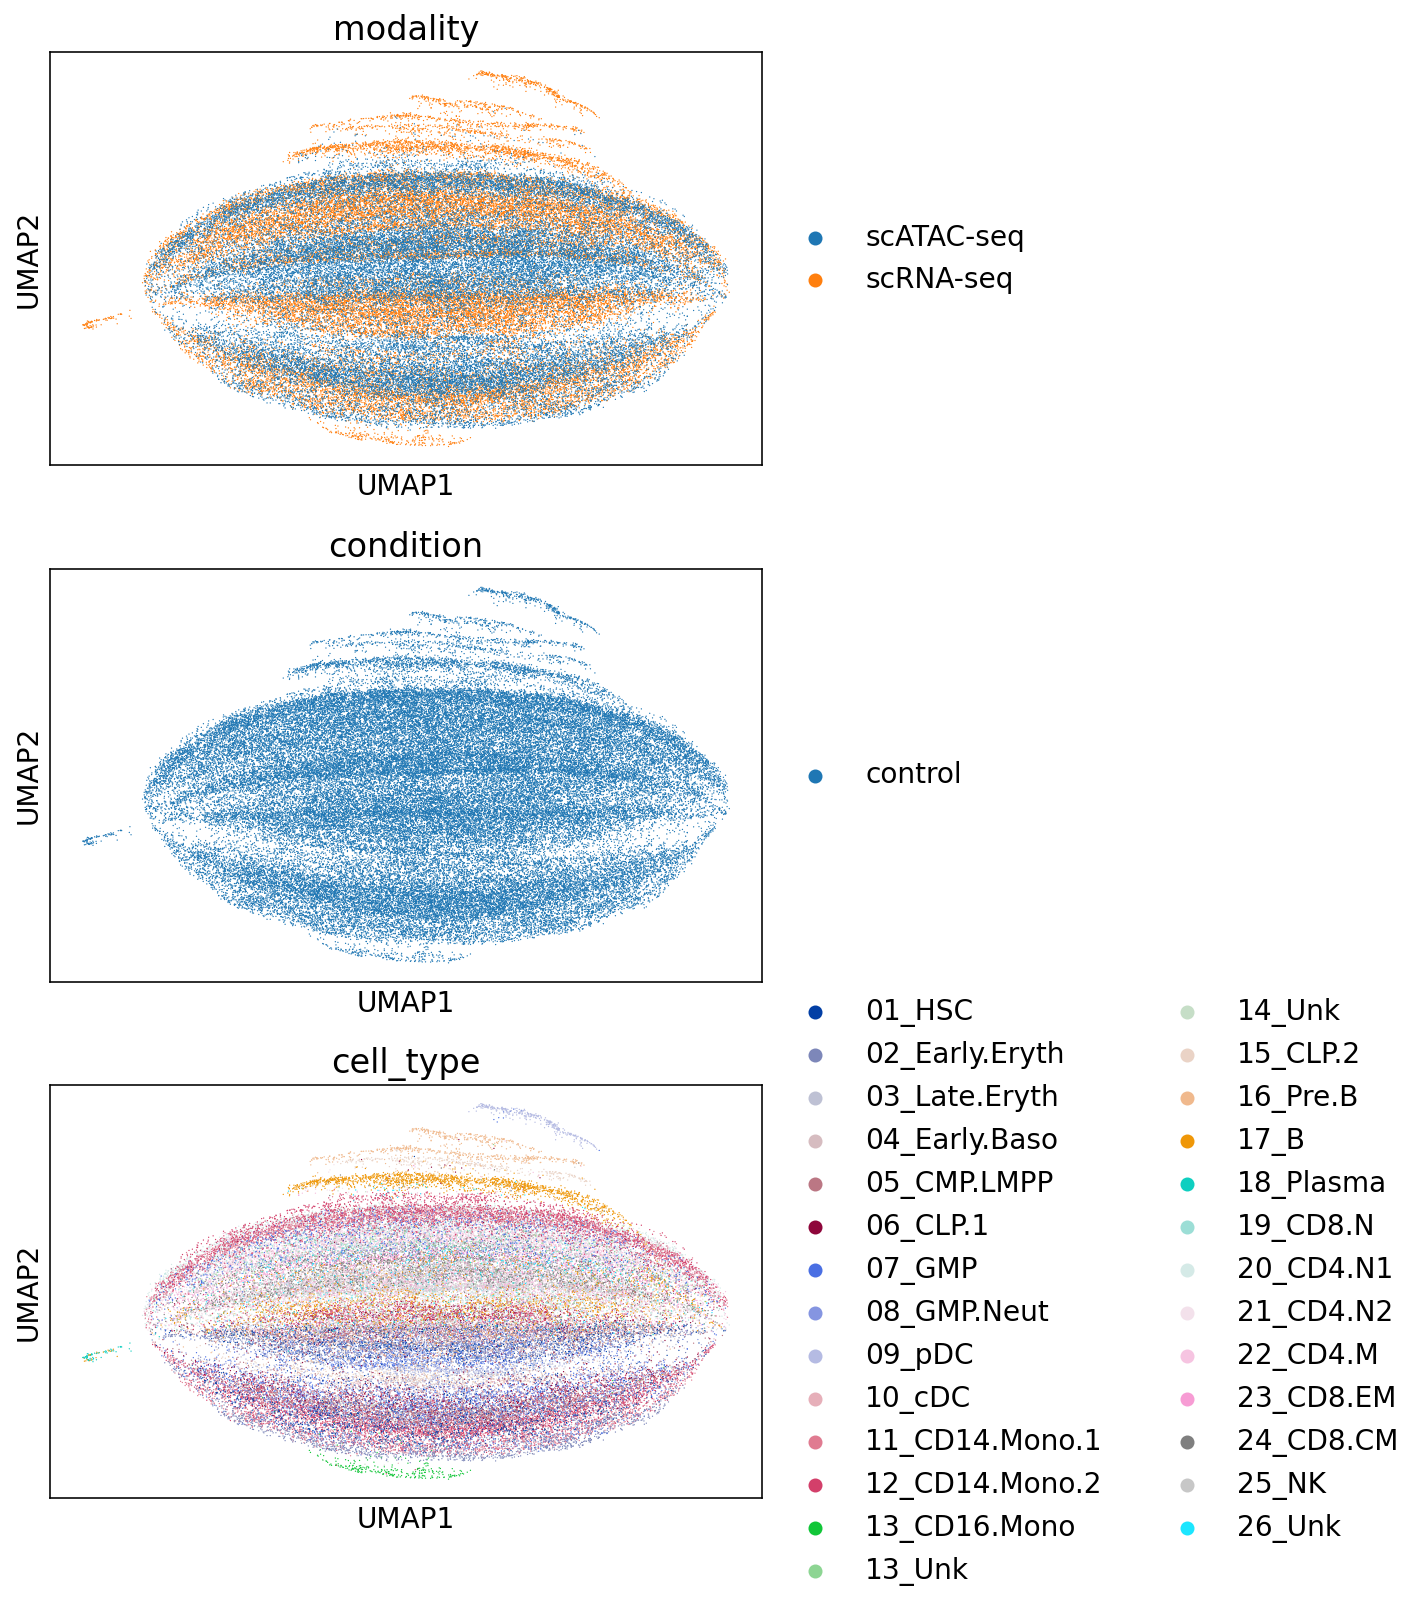

CPU times: user 4min 2s, sys: 4.4 s, total: 4min 7s
Wall time: 1min 59s


In [19]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)